In [1]:
import numpy as np

In [2]:
%env JAX_ENABLE_X64=True

env: JAX_ENABLE_X64=True


In [3]:
from lenstronomy.LensModel.lens_model import LensModel
import lensinggw.constants.constants as const
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle

In [4]:
import sys
import os
dir = 'home/manchun.yeung/microlensing/wolensing_simon/wolensing'
dir1 = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(dir)

In [5]:
dir

'home/manchun.yeung/microlensing/wolensing_simon/wolensing'

In [6]:
from wolensing.plot.plot import plot_contour
import wolensing.amplification_factor.amplification_factor as af

The macroimage where the microlens is placed around.

In [7]:
type2 = True

In [8]:
ym = 0.5
angle = np.radians(float(0))

Importing constants

In [9]:
G = const.G  # gravitational constant [m^3 kg^-1 s^-2]
c = const.c  # speed of light [m/s]
M_sun = const.M_sun  # Solar mass [Kg]

In [10]:
y0, y1 = 0.1, 0 # source position
l0, l1 = 0., 0 # lens position

zS = 1.0 # source redshift
zL = 0.5 # lens redshift

In [11]:
mL1 = 1e10
mL2 = 100
mtot = mL1 + mL2

# convert to radians
from lensinggw.utils.utils import param_processing
thetaE1 = param_processing(zL, zS, mL1)
thetaE2 = param_processing(zL, zS, mL2)
thetaE = param_processing(zL, zS, mtot)

In [30]:
thetaE2

8.052888061582412e-11

In [13]:
from wolensing.utils.utils import Einstein_radius

In [21]:
Einstein_radius(0.5,1,1e10)

141457.81152155242

In [23]:
import lensinggw.constants.constants as const

Msun_Kg         = const.M_sun                             # Msun (Kg)
Mpc             = const.Mpc                               # 1 Megaparsec in meters
arcsec2rad      = np.pi/(648000)                          # conversion factor from arcsec to radian
G               = const.G                                 # gravitational constant (m3*Kg-1*s-2)
c               = const.c                                 # speed of light (m/s)

def param_processing1(zL, zS, mL, cosmo=None):
    """
    Computes the Einstein radius of a given lens
    
    :param zL: lens redshift
    :type zL: float
    :param zS: source redshift
    :type zS: float
    :param mL: lens mass
    :type mL: float
    :param cosmo: cosmology used to compute angular diameter distances, *optional*. If not specified, a :math:`\\mathrm{FlatLambdaCDM}` instance with :math:`H_0=69.7, \Omega_0=0.306, T_{cmb0}=2.725` is considered
    :type cosmo: instance of the astropy cosmology class
    
    :returns: the lens Einstein radius in radians, :math:`\\theta_E = \\sqrt{\\frac{4Gm_L}{c^2}\\frac{D_{LS}}{D_L D_S}}`
    :rtype: float
    """
    
    # set a default flat cosmology if not given
    if cosmo is None: 
        from astropy.cosmology import FlatLambdaCDM
        cosmo = FlatLambdaCDM(H0=69.7, Om0=0.306, Tcmb0=2.725)
    
    # process input parameters    
    DL       = cosmo.angular_diameter_distance(zL)
    DS       = cosmo.angular_diameter_distance(zS)
    DLS      = cosmo.angular_diameter_distance_z1z2(zL, zS)
    D        = DLS/(DL*DS)
    D        = np.float64(D/(Mpc))
    theta_E2 = (4*G*mL*Msun_Kg*D)/c**2                                                                                                                                                                                                                                                                                                                                                                                                                            
    theta_E  = np.sqrt(theta_E2) 
    
    return theta_E, DL, DS, DLS, D, theta_E2

In [24]:
param_processing1(0.5,1,1e10)

(8.052888061582411e-07,
 <Quantity 1261.82528171 Mpc>,
 <Quantity 1653.00855925 Mpc>,
 <Quantity 706.63959797 Mpc>,
 1.097926071881248e-26,
 6.484900613237653e-13)

In [29]:
Mpc

3.085677581491367e+22

In [27]:
def Einstein_radius1(zL, zS, mL):
    '''
    :param zL: redshift where the lens locates
    :param zS: redshift where the source locates
    :param mL: lens mass
    :return: Einstein radius of the lens system
    '''

    from astropy.cosmology import FlatLambdaCDM
    import astropy.units as u
    cosmo = FlatLambdaCDM(H0=69.7, Om0=0.306, Tcmb0=2.725)

    DL       = cosmo.angular_diameter_distance(zL)
    DS       = cosmo.angular_diameter_distance(zS)
    DLS      = cosmo.angular_diameter_distance_z1z2(zL, zS)
    D        = DLS/(DL*DS)
    D        = np.float64(D/(Mpc))
    theta_E2 = (4*const.G*mL*const.M_sun*D)/const.c**2
    theta_E  = np.sqrt(theta_E2)

    return theta_E, DL, DS, DLS, D, theta_E2

In [28]:
Einstein_radius1(0.5, 1, 1e10)

(8.052888061582411e-07,
 <Quantity 1261.82528171 Mpc>,
 <Quantity 1653.00855925 Mpc>,
 <Quantity 706.63959797 Mpc>,
 1.097926071881248e-26,
 6.484900613237653e-13)

In [12]:
beta0, beta1 = y0 * thetaE, y1 * thetaE
eta10, eta11 = 0 * l0 * thetaE, 0 * l1 * thetaE
lens_model_list = ['SIS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_lens_list = [kwargs_sis_1]

kwargs_sis_1_scaled = {'center_x': eta10 / thetaE, 'center_y': eta11 / thetaE, 'theta_E': thetaE1 / thetaE}
kwargs_lens_list_scaled = [kwargs_sis_1_scaled]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 5 * thetaE2,
                 'OverlapDistMacro': 1e-17,
                 'OnlyMacro': True}
MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                     source_pos_y=beta1,
                                                     lens_model_list=lens_model_list,
                                                     kwargs_lens=kwargs_lens_list,
                                                     **solver_kwargs)

Td = TimeDelay(MacroImg_ra, MacroImg_dec,
                beta0, beta1,
                zL, zS,
                lens_model_list, kwargs_lens_list)
Mus = magnifications(MacroImg_ra, MacroImg_dec, lens_model_list, kwargs_lens_list)
if type2:
    microtype = np.nonzero(Td)[0][0]
else:
    microtype = np.where(Td==0)[0][0]

# Injecting microlens around desired macroimage
eta20, eta21 = MacroImg_ra[microtype] + np.cos(angle)*ym*thetaE2, MacroImg_dec[microtype] + np.sin(angle)*ym*thetaE2
lens_model_list = ['SIS', 'POINT_MASS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_point_mass_2 = {'center_x': eta20, 'center_y': eta21, 'theta_E': thetaE2}
kwargs_lens_list = [kwargs_sis_1, kwargs_point_mass_2]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 10 * thetaE2,
                 'Pixels': 1e3,
                 'OverlapDist': 1e-18,
                 'OverlapDistMacro': 1e-17}
solver_kwargs.update({'Improvement' : 0.1})
solver_kwargs.update({'MinDist' : 10**(-7)})

Img_ra, Img_dec, MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                                      source_pos_y=beta1,
                                                                      lens_model_list=lens_model_list,
                                                                      kwargs_lens=kwargs_lens_list,
                                                                      **solver_kwargs)
Images_dict = {'Source_ra': beta0,
               'Source_dec': beta1,
               'Img_ra': Img_ra,
               'Img_dec': Img_dec,
               'MacroImg_ra': MacroImg_ra,
               'MacroImg_dec': MacroImg_dec,
               'Microlens_ra': [eta20],
               'Microlens_dec': [eta21],
               'thetaE': thetaE}

# time delays, magnifications, Morse indices 
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
from lensinggw.amplification_factor.amplification_factor import geometricalOpticsMagnification
tds = TimeDelay(Img_ra, Img_dec,
               beta0, beta1,
               zL, zS,
               lens_model_list, kwargs_lens_list)
mus = magnifications(Img_ra, Img_dec, lens_model_list, kwargs_lens_list)
ns = getMinMaxSaddle(Img_ra, Img_dec, lens_model_list, kwargs_lens_list, diff = None)
print('Time delays (seconds): ', tds)
print('magnifications: ', mus)
print('Morse indices: ', ns)
    
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(Img_ra[microtype], Img_dec[microtype], kwargs_lens_list, beta0, beta1)#[0]
if not isinstance(T0, float):
    T0 = T0[0]
Tscale = 4 * (1 + zL) * mtot * M_sun * G / c ** 3
print('T0 = {}'.format(T0))
print('Tscale = {}'.format(Tscale))

/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:107: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:107: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:108: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:117: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:117: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packa


---- Will perform only the macromodel analysis ----

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> True
Scaled            --> False
SearchWindowMacro --> 8.052888061582412e-06
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-7.24759925e-07  8.85817687e-07]
dec: [-4.23516474e-22 -4.23516474e-22]


---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> False
Scaled            --> False
SearchWindowMacro --> 8.052888061582412e-06
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-7.24759925e-07  8.85817687e-07]
dec: [-4.23516474e-22 -4.23516474e-22]


---- Solver settings --

In [13]:
# plot only the microimages around the desired macroimage
Img_ra = np.delete(Img_ra, [-1])
Img_dec = np.delete(Img_dec, [-1])

In [14]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# plot_contour(ax, lens_model_list, eta10, eta11, 4*thetaE1, kwargs_lens_list, beta0, beta1, MacroImg_ra, MacroImg_dec,
#                     T0 = T0, Tfac = (thetaE)**(-2), micro=False)


In [15]:
# fig1, ax1 = plt.subplots()
# plot_contour(ax1, lens_model_list, MacroImg_ra[microtype], MacroImg_dec[microtype], 8*thetaE2, kwargs_lens_list, beta0, beta1, Img_ra, Img_dec,
#                     T0 = T0, Tfac = (thetaE)**(-2), micro=True)

In [16]:
# Define the characteristic WindowSize
mL3 = 10
thetaE3 = param_processing(zL, zS, mL3)

In [17]:
import time

In [18]:
kwargs_macro = {'source_pos_x': beta0,
                'source_pos_y': beta1,
                'theta_E': thetaE,
                'mu': Mus[microtype],
               }

kwargs_integrator = {'PixelNum': int(40000),
                     'PixelBlockMax': 2000,
                     'WindowSize': 2.*210*thetaE3,
                     'WindowCenterX': MacroImg_ra[microtype],
                     'WindowCenterY': MacroImg_dec[microtype],
                     'T0': T0,
                     'TimeStep': 1e-5/Tscale, 
                     'TimeMax': T0 + 1/Tscale,
                     'TimeMin': T0 - .1/Tscale,
                     'TimeLength': 1.2/Tscale,
                     'TExtend': 10/Tscale,
                     'LastImageT': .02/Tscale,
                     'Tbuffer': 0,
                     'Tscale': Tscale}


amplification = af.amplification_factor(lens_model_list=lens_model_list, kwargs_lens=kwargs_lens_list, kwargs_macro=kwargs_macro, **kwargs_integrator)
ws = np.loadtxt('./data/t2_20ws_0.5.txt')
Fws = np.loadtxt('./data/t2_20Fws_0.5.txt', dtype=complex, converters={0: lambda s: complex(s.decode().replace('+-', '-'))})
amplification.importor(freq=True, fs=ws, Fws=Fws)
# ts, Ft = amplification.integrator(gpu=False)
# ws, Fws = amplification.fourier()
# amplification.plot_freq()

In [19]:
# plt.plot(ts, Ft)

<Figure size 640x480 with 0 Axes>

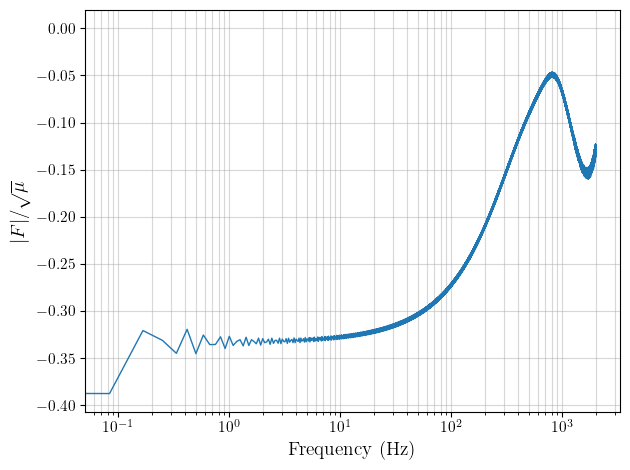

<Axes: xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [20]:
amplification.plot_freq(smooth=False)

In [21]:
# amplification.plot_freq(pha=True, smooth=False)

# Geometrical optics
To get the geometrical optics around type 1 image, we need the magnifications, time delay and the image positions of the microimages

In [22]:
mus = mus[:-1]
tds = tds[:-1]

In [23]:
mus

array([-0.86205803, -0.2162244 ])

In [24]:
geofs, geoFws = amplification.geometrical_optics(mus, tds, Img_ra, Img_dec, upper_lim=2000, type2=False)

In [25]:
len(ws)

24000

In [26]:
index = np.argmin(tds)
overall_phase = np.exp(-1 * 2 * np.pi * 1j * (tds[index]) * amplification._geofs)
geoFws*=overall_phase

In [27]:
len(Fws), len(geoFws)

(24000, 24000)

In [28]:
from wolensing.utils.utils import *
ns = Morse_indices(amplification._lens_model_list, Img_ra, Img_dec, amplification._kwargs_lens)

In [29]:
ns

array([0.5, 0.5])

In [30]:
Fmag = 0
for i in range(len(mus)):
    Fmag += np.sqrt(np.abs(mus[i]))* np.exp(1j*np.pi*(2.*geofs*tds[i] - ns[i]))
    
index = np.argmin(tds)
overall_phase = np.exp(-1 * 2 * np.pi * 1j * (tds[index]) * geofs)
Fmag *= overall_phase

In [31]:
len(geofs), len(geoFws)

(24000, 24000)

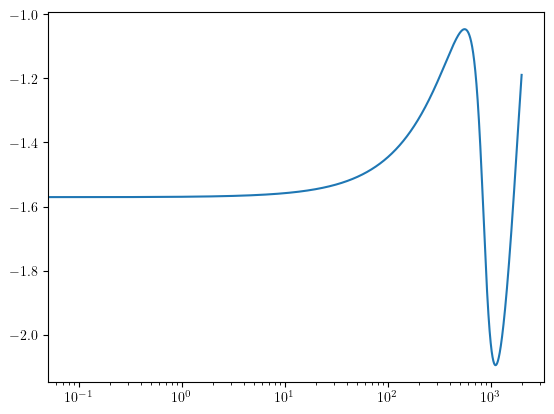

In [32]:
plt.semilogx(geofs, np.angle(Fmag))

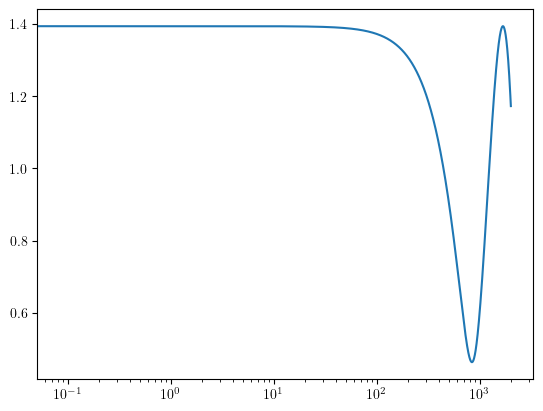

In [33]:
plt.semilogx(geofs, np.abs(geoFws))

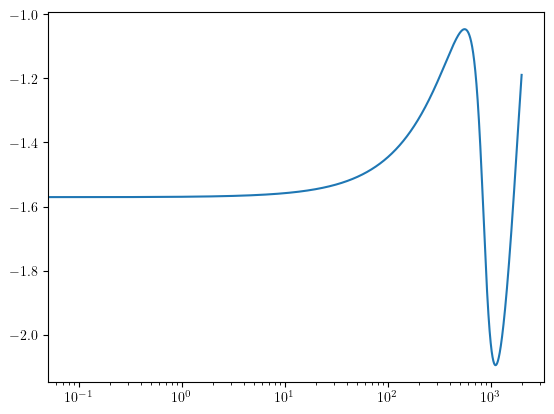

In [34]:
plt.semilogx(geofs, np.angle(geoFws))

# Full amplification factor concatenated with geometrical optics
Given the computaional cost of the diffraction integral, we concatenate the result of wave optics at low frequency and geometrical optics at high frequency to obtain a full amplification factor with default upper bound of 3000Hz.

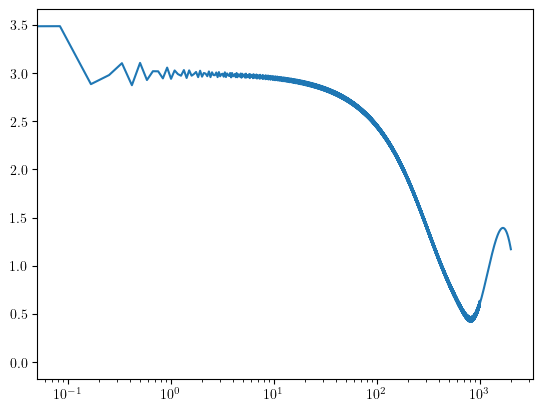

In [35]:
fullfs, fullFws = amplification.concatenate()
plt.semilogx(fullfs, np.abs(fullFws))

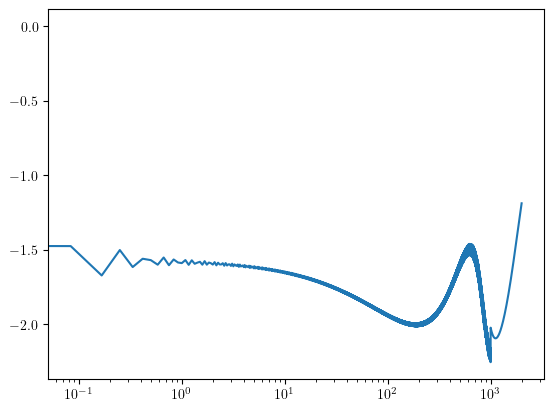

In [36]:
plt.semilogx(fullfs, np.angle(fullFws))

In [37]:
fac = np.sqrt(np.abs(Mus[microtype]))

In [38]:
plt.clf()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

<Figure size 640x480 with 0 Axes>

In [39]:
from bisect import bisect_left
low_index = bisect_left(geofs, 1)
geofs = geofs[low_index:]
geoFws = geoFws[low_index:]
ws = ws[low_index:]
Fws = Fws[low_index:]

(1, 2000)

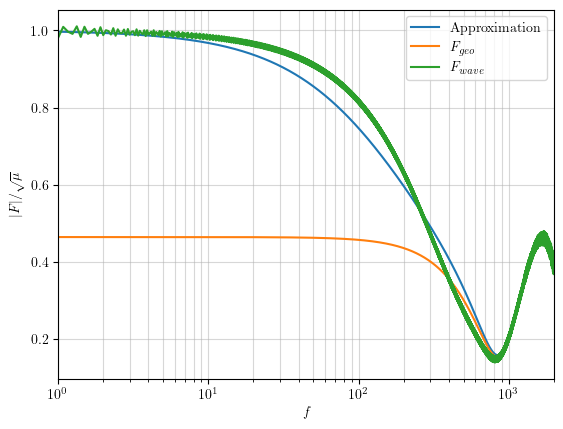

In [40]:
ww = geofs
plt.semilogx(geofs, (fac*np.exp(-ww*np.pi/500) + (1-np.exp(-ww*np.pi/500))*np.abs(geoFws))/fac, label='Approximation')
plt.semilogx(geofs, np.abs(geoFws)/fac,label=r'$F_{geo}$')
plt.semilogx(ws, np.abs(Fws)/fac, label=r'$F_{wave}$')
plt.ylabel(r'$|F|/\sqrt{\mu}$')
plt.xlabel(r'$f$')
plt.grid(which='both', alpha=0.5)
plt.legend()
plt.xlim(1, 2000)

(1, 2000)

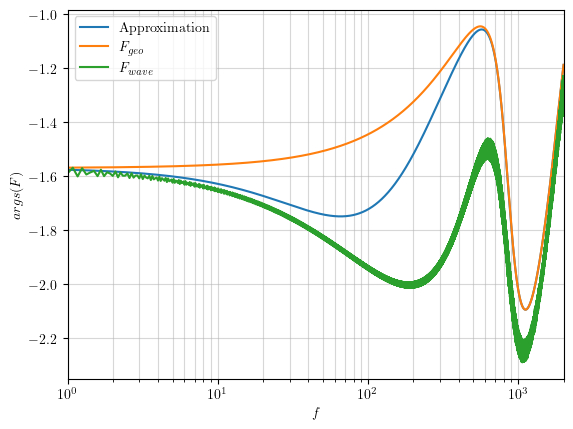

In [41]:
plt.semilogx(geofs, ((-np.pi/2-ww/150)*np.exp(-ww*np.pi/300))+(1-np.exp(-ww*np.pi/300))*(np.angle(geoFws)), label='Approximation')
plt.semilogx(geofs, np.angle(geoFws),label=r'$F_{geo}$')
plt.semilogx(ws, np.angle(Fws), label=r'$F_{wave}$')
plt.ylabel(r'$args(F)$')
plt.xlabel(r'$f$')
plt.grid(which='both', alpha=0.5)
plt.legend()
plt.xlim(1, 2000)

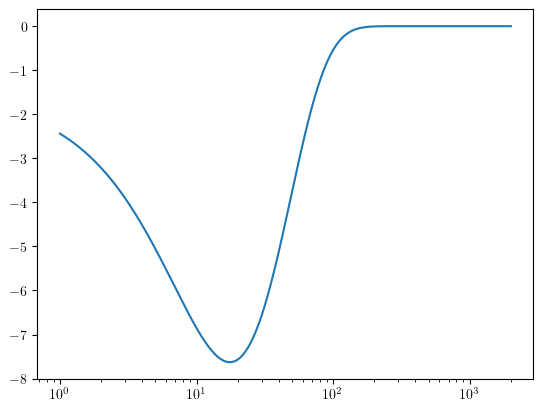

In [42]:
plt.semilogx(geofs, (-np.pi/2-ww)*np.exp(-ww*np.pi/60))
# plt.semilogx(geofs, (-np.pi/2-(-np.pi/2)*np.exp(-ww*np.pi/60)))
# plt.semilogx(geofs, (1-np.exp(-ww*np.pi/60))*np.angle(geoFws))

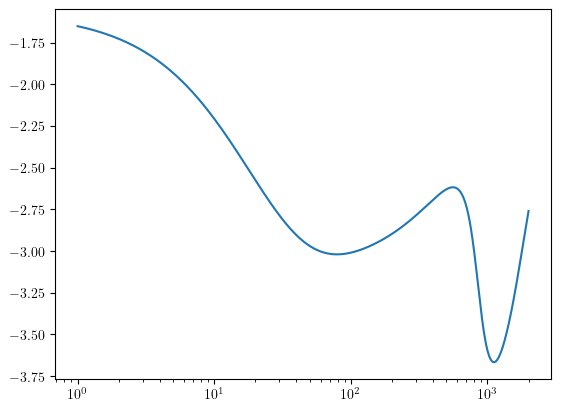

In [43]:
plt.semilogx(geofs, ((-np.pi/2)*np.exp(-ww*np.pi/60)+np.pi/2)+((np.pi/2)*np.exp(-ww*np.pi/60)-np.pi)+(1-np.exp(-ww*np.pi/60))*np.angle(geoFws))

In [44]:
Abs = (fac*np.exp(-ww*np.pi/1000) + (1-np.exp(-ww*np.pi/1000))*np.abs(geoFws))/fac
Pha = (1-np.exp(-ww*np.pi/1000))*np.angle(geoFws)
complete_approx = Abs * np.exp(1j * Pha)

<Figure size 640x480 with 0 Axes>

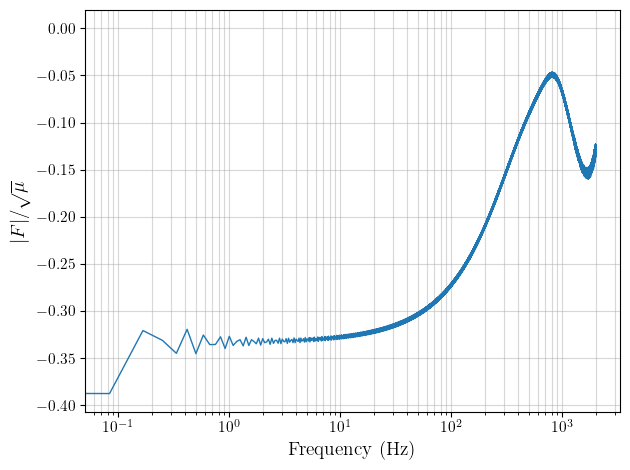

<Axes: xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [45]:
amplification.plot_freq()

<Figure size 640x480 with 0 Axes>

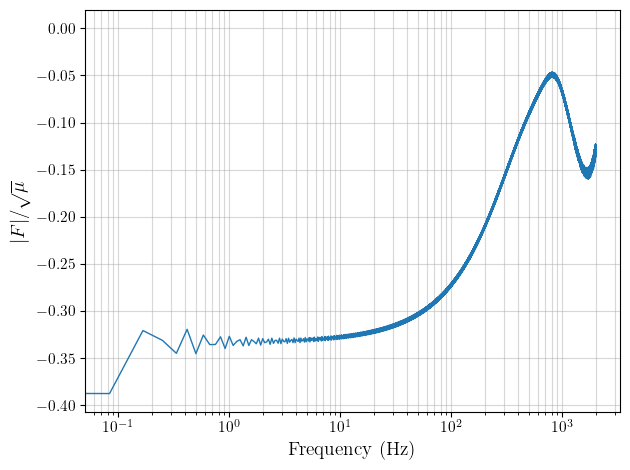

<Axes: xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [46]:
amplification.plot_freq(smooth=False)

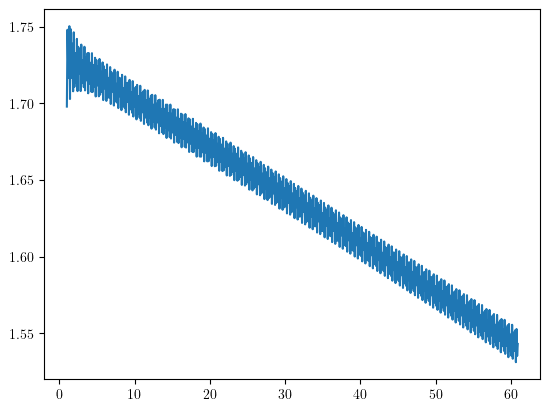

In [47]:
plt.plot(ws[:720], np.abs(Fws[:720])/np.sqrt(3))

In [48]:
from bisect import bisect_left
i = bisect_left(ws, 60)


In [49]:
i

709

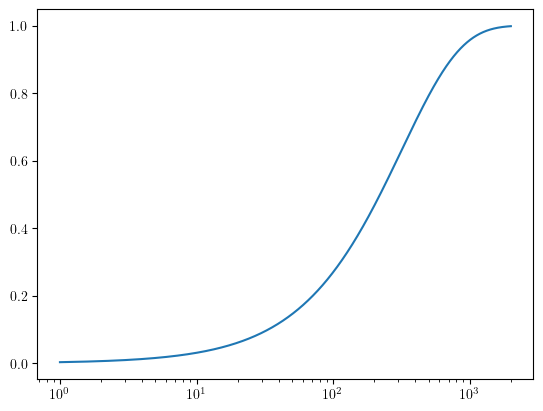

In [50]:
plt.semilogx(ww,(1-np.exp(-ww*np.pi/1000)))

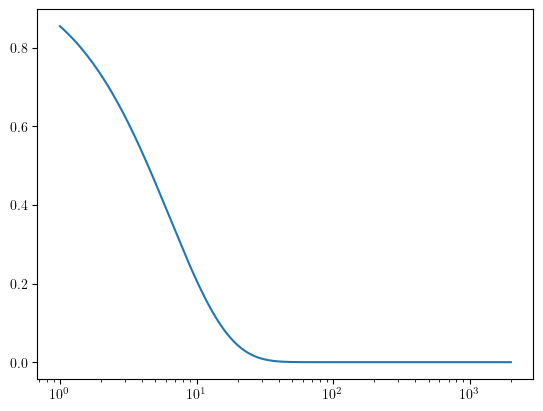

In [51]:
plt.semilogx(ww, np.exp(-ww*np.pi/20))

In [52]:
import pycbc.psd as psd
from pycbc.filter.matchedfilter import overlap, match

hp, hc = get_fd_waveform(approximant = 'IMRPhenomXPHM',
                         mass1 = 30,
                         mass2 = 30,
                         delta_f = .04,
                         f_lower = 10,
                         f_final = 2000)
dfnoise = 0.04
noiselen = int(2001/dfnoise)+1
noise2 = psd.analytical.aLIGOaLIGODesignSensitivityT1800044(noiselen, dfnoise, 1)
noisef = np.linspace(1, 1 + dfnoise*(noiselen-1), num = noiselen)

/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


NameError: name 'get_fd_waveform' is not defined

In [ ]:
np.savetxt('gf.txt', geofs)
np.savetxt('complete.txt', complete_approx)
np.savetxt('ws.txt', ws)
np.savetxt('Fws.txt', Fws)

In [ ]:
np.savetxt('gwoF.txt', geoFws)

In [ ]:
mus, tds, ns

In [ ]:
Img_ra

In [ ]:
from wolensing.utils.utils import *
Morse_indices(amplification._lens_model_list, Img_ra, Img_dec, amplification._kwargs_lens)

In [ ]:
plt.plot(geofs, -0.000435*geofs + np.pi - 23/geofs)